In [1]:
%load_ext autoreload
%autoreload 2
# %config Application.verbose_crash=True

In [2]:
import os
from src.dataclasses.transactions import Transactions
from src.dataclasses.ticker import Ticker
from src.dataclasses.holdings import Holdings
from src.dataclasses.prices import Prices
from src.dataclasses.subscriptions import Subscriptions

from src.utils.defaults import DEFAULT_RFR

## Load in subscriptions

In [3]:
subscriptions = Subscriptions.from_csv(os.getcwd() + "/data/subscriptions.csv")
subscriptions.data.head()

,Portfolio,GBP,USD
Date,,,
2022-02-09,LISA,2003.15,2713.780671
2022-02-10,0,0.00,0.000000
2022-02-11,0,0.00,0.000000
2022-02-12,0,0.00,0.000000
2022-02-13,0,0.00,0.000000


## Load in transactions

In [4]:
transactions = Transactions.from_csv(os.getcwd() + "/data/full_transaction_history.csv")
transactions.raw_data.head()

,Portfolio,Date,Transaction,Description,Quantity,Price,Ticker
0,LISA,2022-02-09,Purchase,GameStop Corp Class A,82,24.13,GME
1,ISA,2022-04-11,Purchase,iShares Core S&P 500 ETF USD Acc GBP,8,345.20,CSP1.L
2,LISA,2022-05-10,Purchase,GameStop Corp Class A,42,23.09,GME
3,ISA,2022-05-12,Purchase,iShares Core S&P 500 ETF USD Acc GBP,5,342.01,CSP1.L
4,LISA,2022-08-23,Purchase,GameStop Corp Class A,32,30.00,GME


In [5]:
Ticker("GBPUSD=X", is_fx=True).prices.tail()

Date
2025-11-10    1.314268
2025-11-11    1.317297
2025-11-12    1.315288
2025-11-13    1.312784
2025-11-14    1.315218
Freq: D, Name: GBPUSD=X, dtype: float64

In [6]:
from concurrent.futures import ThreadPoolExecutor


pool = ThreadPoolExecutor(max_workers=10)
prices = Prices(transactions=transactions, pool=pool)
prices.data.tail()

Loading prices: 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


,AMZN,AAPL,GME,META,ORCL,GOOG,MU,CSP1.L,GXLK.L,DJEL.L,VUSA.L
Date,,,,,,,,,,,
2025-11-10,248.399994,269.429993,21.490000,631.760010,240.830002,290.589996,253.300003,724.030106,155.451588,475.304933,128.334959
2025-11-11,249.100006,275.250000,21.450001,627.080017,236.149994,291.739990,241.110001,729.071451,155.546486,482.130870,129.233472
2025-11-12,244.199997,273.470001,21.360001,609.010010,226.990005,287.429993,244.899994,733.430666,156.519223,489.977509,129.976719
2025-11-13,237.580002,272.950012,20.959999,609.890015,217.570007,279.119995,236.949997,721.558508,152.978699,482.809076,127.927506
2025-11-14,234.690002,272.410004,20.660000,609.460022,222.850006,276.980011,246.830002,722.370515,154.735438,479.166918,128.046366


In [7]:
prices.data.index

DatetimeIndex(['2015-11-16', '2015-11-17', '2015-11-18', '2015-11-19',
               '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23',
               '2015-11-24', '2015-11-25',
               ...
               '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-08',
               '2025-11-09', '2025-11-10', '2025-11-11', '2025-11-12',
               '2025-11-13', '2025-11-14'],
              dtype='datetime64[ns]', name='Date', length=3652, freq='D')

In [8]:
holdings = Holdings(
    transactions=transactions, prices=prices, subscriptions=subscriptions
)

<Axes: >

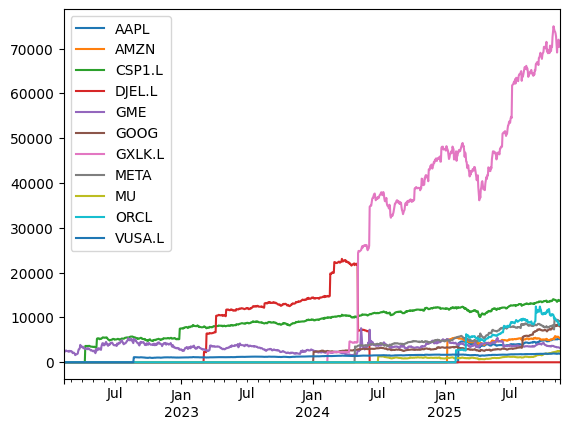

In [9]:
holdings.data.plot()

<Axes: xlabel='Date'>

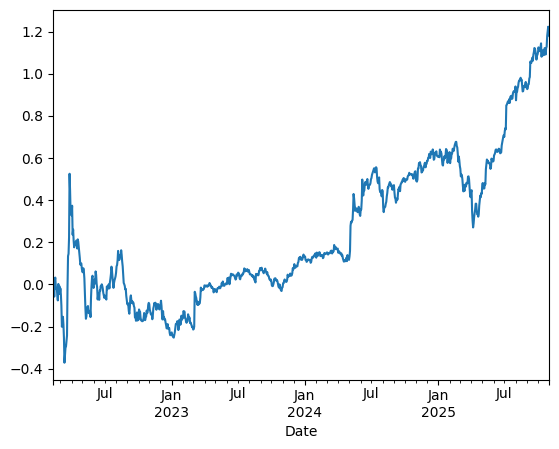

In [10]:
holdings.twr.add(1).cumprod().sub(1).plot()
# holdings.twr[holdings.twr > 0.1].resample("D").sum().fillna(0).plot()

In [11]:
holdings.transactions.data

Ticker,AAPL,AMZN,CSP1.L,DJEL.L,GME,GOOG,GXLK.L,META,MU,ORCL,VUSA.L
2022-02-09,0.0,0.0,0.0,0.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-11-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Date'>

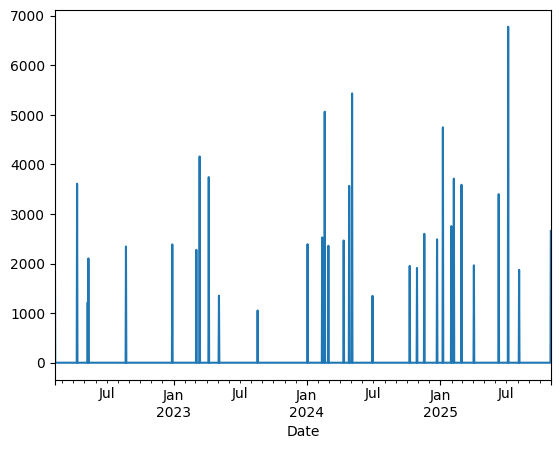

In [12]:
holdings.subscriptions.data["USD"].resample("D").sum().fillna(0).plot()

<Axes: xlabel='Date'>

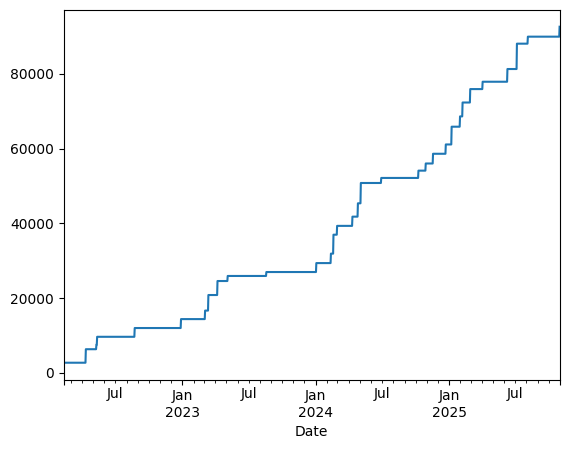

In [13]:
holdings.subscriptions.data["USD"].resample("D").sum().cumsum().fillna(0).plot()

<Axes: >

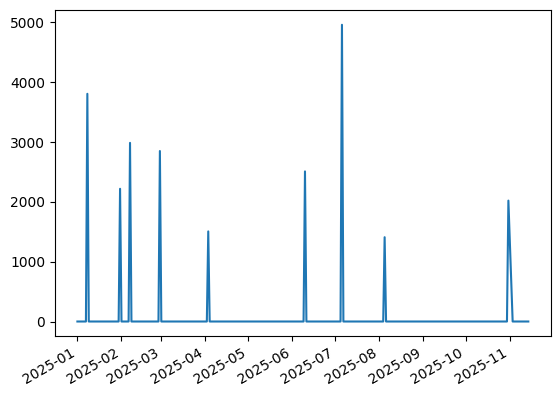

In [14]:
cfs = (
    holdings.subscriptions.data["GBP"]
    # .resample("D")
    # .sum()  # in case of multiple deposits per day
    .reindex(holdings.total.index.union(holdings.subscriptions.data.index))
    .fillna(0.0)
)

cfs["2025":].plot()

In [15]:
holdings.subscriptions.data["GBP"].max()

np.float64(4960.57)

In [16]:
subscriptions.data

,Portfolio,GBP,USD
Date,,,
2022-02-09,LISA,2003.15,2713.780671
2022-02-10,0,0.00,0.000000
2022-02-11,0,0.00,0.000000
2022-02-12,0,0.00,0.000000
2022-02-13,0,0.00,0.000000
...,...,...,...
2025-10-27,0,0.00,0.000000
2025-10-28,0,0.00,0.000000
2025-10-29,0,0.00,0.000000


<Axes: >

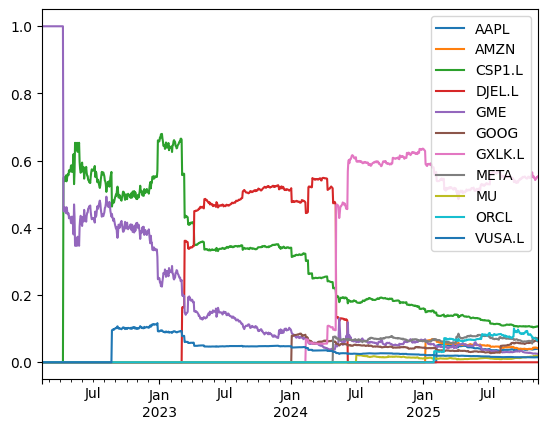

In [17]:
holdings.weights.plot()

In [18]:
bmk = Ticker("^SPX").returns

In [19]:
from src.dataclasses.assessment_config import AssessmentConfig


config = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,
    bmk=bmk,
)

In [22]:
# %tb
from src.evaluation import Evaluation

f = Evaluation(config).run()

9


In [24]:
# Had more capital and more focused on active mgmt
# (switched away from majority holding in DOW)
config_active = AssessmentConfig(
    returns=holdings.twr,
    rfr=DEFAULT_RFR,  # 3mo US Tresury
    bmk=bmk,  # SP500
    start="2024",
)

f_active = Evaluation(config_active).run()
# pd.Series(f_active.results)

9


Time (s)  Mean (s)  Count
Beta summary    0.000215  0.000215      1
     rolling    0.000482  0.000482      1
     expanding  0.000475  0.000475      1
     total      0.001171  0.000390      3

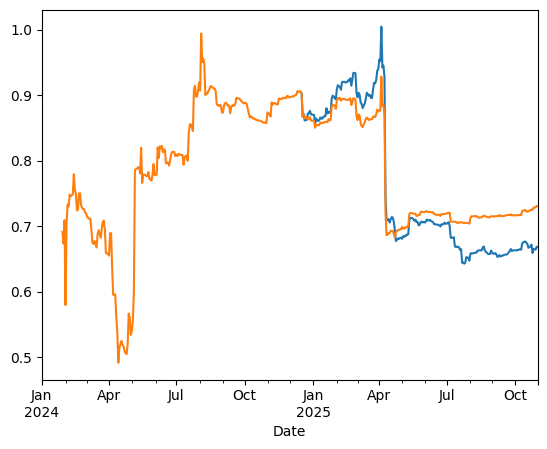

In [43]:
from src.assessments.beta import Beta

beta = Beta(config=config_active)


x = beta.summary()
x = beta.rolling().plot()
x = beta.expanding().plot()

# x.plot()
# bmk["2025":].add(1).cumprod().plot()
# beta.run("summary")
# beta.timer.df
beta.timer.df
#

<Axes: xlabel='Date'>

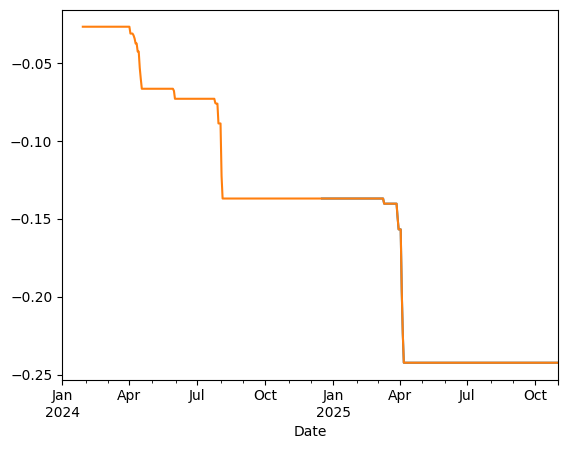

In [44]:
from src.assessments.max_drawdown import MaxDrawdown

max_dd = MaxDrawdown(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

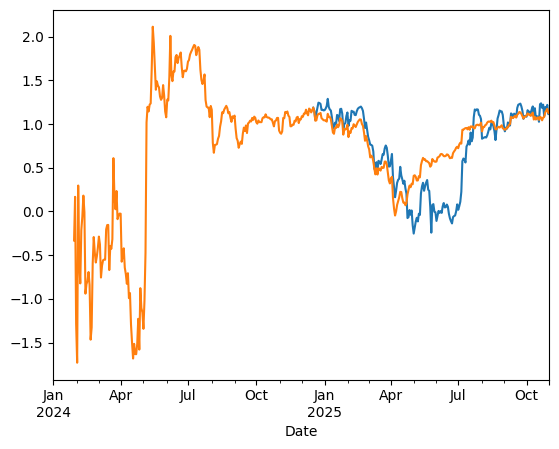

In [45]:
from src.assessments.sharpe_ratio import SharpeRatio

max_dd = SharpeRatio(config=config_active)
max_dd.summary()
max_dd.rolling().plot()
max_dd.expanding().plot()
# max_dd.results

<Axes: xlabel='Date'>

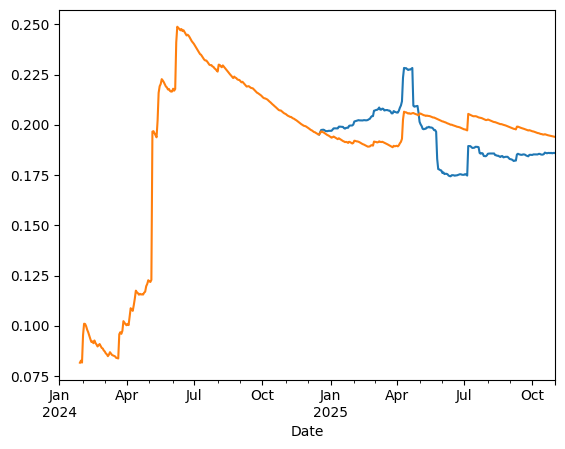

In [46]:
from src.assessments.tracking_error import TrackingError

tracking_error = TrackingError(config=config_active)
# tracking_error.summary()
tracking_error.rolling().plot()
tracking_error.expanding().plot()
# tracking_error.results

Time (s)  Mean (s)  Count
InformationRatio summary    0.000196  0.000196      1
                 rolling    0.000425  0.000425      1
                 expanding  0.000373  0.000373      1
                 total      0.000994  0.000331      3

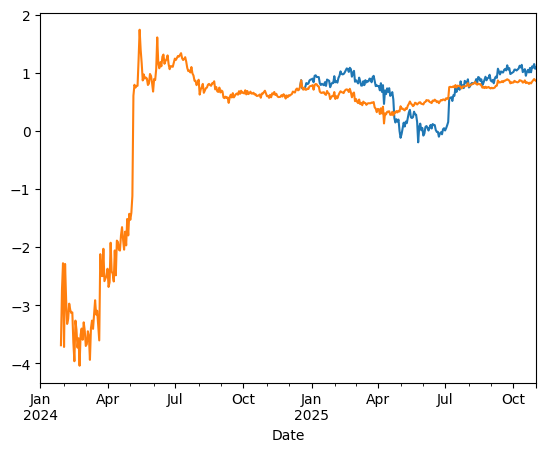

In [47]:
from src.assessments.information_ratio import InformationRatio

information_ratio = InformationRatio(config=config_active)
information_ratio.summary()
information_ratio.rolling().plot()
information_ratio.expanding().plot()
information_ratio.timer.df

<Axes: xlabel='Date'>

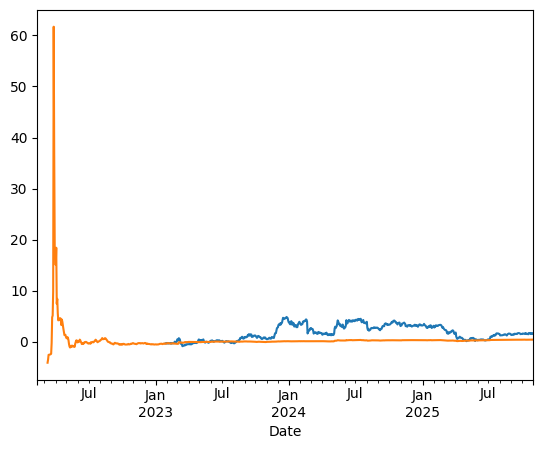

In [48]:
from src.assessments.calmar_ratio import CalmarRatio

calmar_ratio = CalmarRatio(config=config)
calmar_ratio.summary()
calmar_ratio.rolling().plot()
calmar_ratio.expanding().plot()

<Axes: xlabel='Date'>

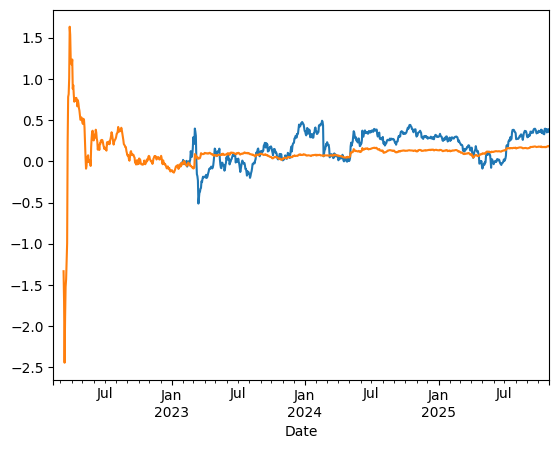

In [49]:
from src.assessments.treynor_ratio import TreynorRatio

treynor_ratio = TreynorRatio(config=config)
treynor_ratio.summary()
treynor_ratio.rolling().plot()
treynor_ratio.expanding().plot()

<Axes: xlabel='Date'>

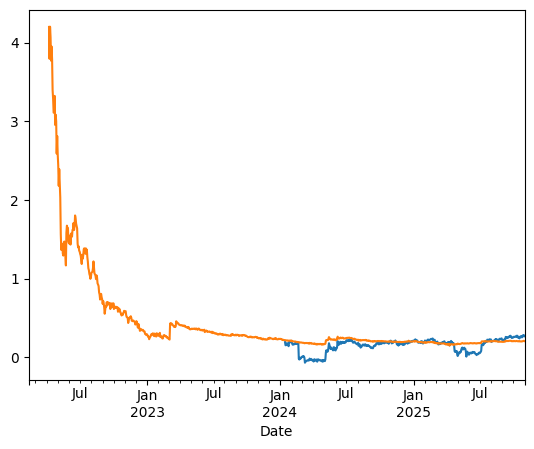

In [50]:
from src.assessments.jensens_alpha import JensensAlpha

jensens_alpha = JensensAlpha(config=config)
jensens_alpha.summary()
jensens_alpha.rolling().plot()
jensens_alpha.expanding().plot()

<Axes: xlabel='Date'>

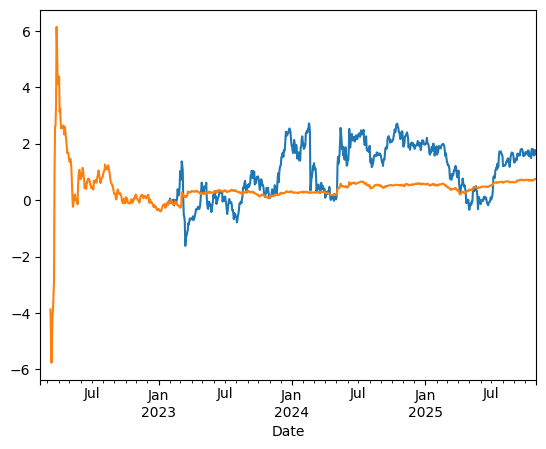

In [51]:
from src.assessments.sortino_ratio import SortinoRatio

sortino_ratio = SortinoRatio(config=config)
sortino_ratio.summary()
sortino_ratio.rolling().plot()
sortino_ratio.expanding().plot()

In [52]:
from src.assessments.beta import Beta


x = Beta(config=config)
x

Beta(config=AssessmentConfig(returns=Date
2022-02-10   -0.014643
2022-02-11    0.014534
2022-02-14   -0.057626
2022-02-15    0.077462
2022-02-16    0.017200
                ...   
2025-10-27    0.024002
2025-10-28    0.010598
2025-10-29    0.009235
2025-10-30   -0.017345
2025-10-31   -0.002164
Freq: B, Length: 972, dtype: float64, rfr=Date
2022-02-10    0.000041
2022-02-11    0.000037
2022-02-14    0.000039
2022-02-15    0.000044
2022-02-16    0.000041
                ...   
2025-10-27    0.000401
2025-10-28    0.000401
2025-10-29    0.000403
2025-10-30    0.000405
2025-10-31    0.000401
Freq: B, Name: Close, Length: 972, dtype: float64, bmk=Date
2022-02-10   -0.018116
2022-02-11   -0.018969
2022-02-14   -0.003841
2022-02-15    0.015767
2022-02-16    0.000881
                ...   
2025-10-27    0.012290
2025-10-28    0.002288
2025-10-29   -0.000044
2025-10-30   -0.009905
2025-10-31    0.002618
Freq: B, Name: Returns, Length: 972, dtype: float64, start=None, end=None, ann_factor=252, w

In [53]:
from dataclasses import dataclass


@dataclass
class Xyz:
    name = "xyz"

    def __repr__(self) -> str:
        return self.name


Xyz.__name__

'Xyz'

<Axes: xlabel='Date'>

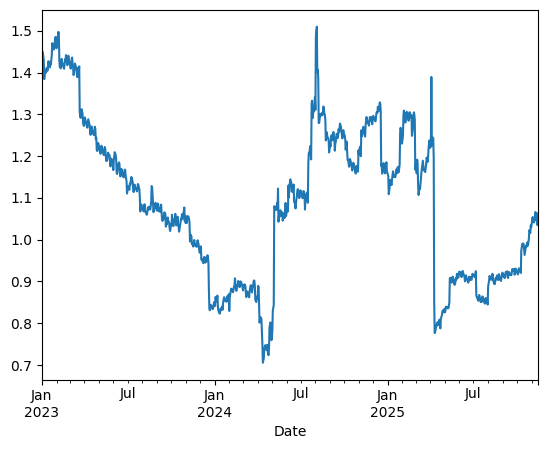

In [54]:
window = 252  # span for EWM

# Portfolio and benchmark returns
returns = holdings.twr
benchmark = bmk

# EWM covariance between portfolio and benchmark
cov_ewm = returns.ewm(span=window).cov(benchmark)

# EWM variance of benchmark
var_ewm = benchmark.ewm(span=window).var()

# EWMA beta
beta_ewm = cov_ewm / var_ewm
beta_ewm["2023":].plot()

<Axes: xlabel='Date'>

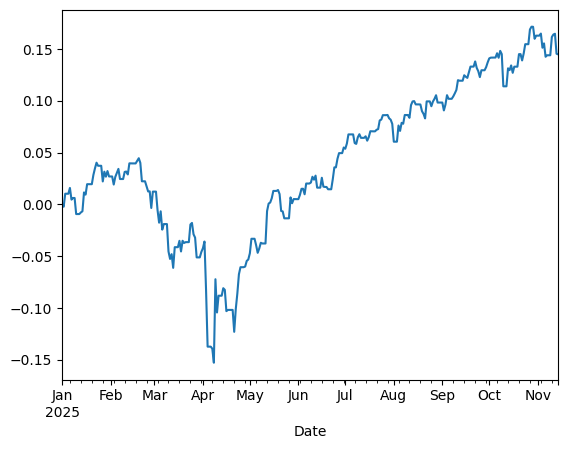

In [55]:
bmk["2025":].add(1).cumprod().sub(1).plot()

<Axes: xlabel='Date'>

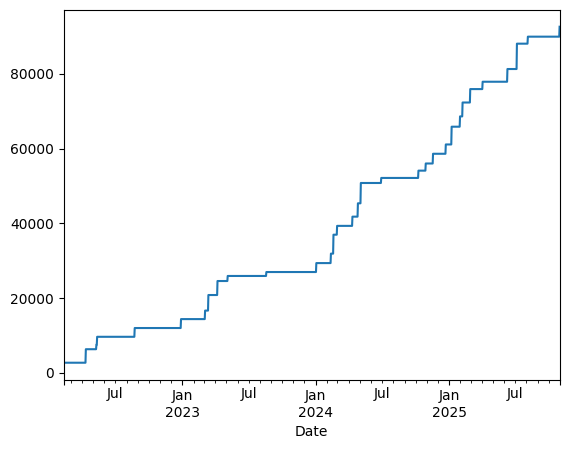

In [56]:
subscriptions.data["USD"].cumsum().plot()

In [57]:
from src.evaluation import Evaluation


e = Evaluation(config_active).with_assessments(
    # {AssessmentName.CAGR}
)
e.run()

9


Evaluation

In [58]:
e.display_timer_stats()

2025-11-15 20:31:18 WARNING [src.evaluation] No timer stats to display. Run evaluation first.


In [41]:
t = Ticker("ORCL")

In [42]:
t.prices.resample("ME").last().pct_change().std() * 2

np.float64(0.16980982528877034)